#### Imports

In [17]:
using Plots
using Random

# Motion Planning Using Convex Optimization

## Model

In [18]:
struct Point
    x::Float64
    y::Float64
end

In [19]:
struct Pose
    position::Point
    orientation::Float64
end

## General Functions

In [20]:
function angleCalculator(dif_x, dif_y)
    ang_aux = 180*atan(dif_y,dif_x)/pi
    println("Raw angle = ", ang_aux)
    if (dif_x >=0 && dif_y >= 0) #top right
        ang_aux = 180 - ang_aux
    elseif (dif_x >=0 && dif_y < 0) #bot right
        ang_aux = abs(ang_aux) + 180
    elseif (dif_x < 0 && dif_y >= 0) #top left
        ang_aux = 180 - ang_aux
    elseif (dif_x < 0 && dif_y < 0) #bot left
        ang_aux = abs(ang_aux) + 180
    end
    println("Corrected angle = ", ang_aux, "\n\n")

    return ang_aux
end

angleCalculator (generic function with 1 method)

## Random Map Generation

### Random Convex Polygon Generation

In [21]:
function GenerateRandomConvexPolygon(numberOfVertices::Int64)
    # Still remains a test for convexity and 
    #keep up with the computation until a convex poligon is found
    
    xCoordinateRandomPoints = []
    yCoordinateRandomPoints = []

    #Generate two lists of random X and Y coordinates
    
    for i in 1:numberOfVertices
        append!(xCoordinateRandomPoints, rand())
        append!(yCoordinateRandomPoints, rand(0:0.001:1))
        println("X gerado: ", xCoordinateRandomPoints[i],", Y gerado: ", yCoordinateRandomPoints[i],)
    end

    println("\n\n")

    #Sort them

    sort!(xCoordinateRandomPoints)
    sort!(yCoordinateRandomPoints)
    println("ordenando...")

    for i in 1:numberOfVertices
        println("X: ", xCoordinateRandomPoints[i],", Y: ", yCoordinateRandomPoints[i],)
    end

    #Isolate the extreme points
    minimumX = xCoordinateRandomPoints[1]
    maximumX = xCoordinateRandomPoints[numberOfVertices]
    minimumY = yCoordinateRandomPoints[1]
    maximumY = yCoordinateRandomPoints[numberOfVertices]


    xVectors = []
    yVectors = []

    lastTop = minimumX
    lastBot = minimumX;

    println("separando em duas correntes...")
    for i in 2:numberOfVertices-1
        x = xCoordinateRandomPoints[i];

        if rand(Bool) #Randomly divide the interior points into two chains
            append!(xVectors, x - lastTop) #Extract the vector components
            lastTop = x;
        else 
            append!(xVectors, lastBot - x)
            lastBot = x;
        end
        println("xVectors[", i-1, "] = ", xVectors[i-1])
    end

    append!(xVectors, maximumX - lastTop)
    append!(xVectors, lastBot - maximumX)

    lastLeft = minimumY
    lastRight = minimumY;

    for i in 2:numberOfVertices-1
        y = yCoordinateRandomPoints[i];

        if rand(Bool)
            append!(yVectors, y - lastLeft)
            lastLeft = y;
        else 
            append!(yVectors, lastRight - y)
            lastRight = y;
        end
    end

    append!(yVectors, maximumY - lastLeft)
    append!(yVectors, lastRight - maximumY)

    #Randomly pair up the X- and Y-components
    #Combine the paired up components into vectors
    shuffle(yVectors);

    points = []
    angles = []
    ang_aux = 0
    for i in 1:numberOfVertices
        push!(points, Point(xVectors[i],yVectors[i]))
        println("Ponto ", i, ": x = ", points[i].x, ", e y = ", points[i].y)
        ang_aux = 180*atan(yVectors[i],xVectors[i])/pi
        println("Ângulo cru = ", ang_aux)
        if (xVectors[i] >=0 && yVectors[i] >= 0) #top right
            ang_aux = 180 - ang_aux
        elseif (xVectors[i] >=0 && yVectors[i] < 0) #bot right
            ang_aux = abs(ang_aux) + 180
        elseif (xVectors[i] < 0 && yVectors[i] >= 0) #top left
            ang_aux = 180 - ang_aux
        elseif (xVectors[i] < 0 && yVectors[i] < 0) #bot left
            ang_aux = abs(ang_aux) + 180
        end
        append!(angles, ang_aux)
        println("Com ângulo = ", angles[i], "\n\n")
    end

    #Sort the vectors by angle
    order = sortperm(angles)
    points = points[order]

    for p in points
        println(p.x,", ",p.y)
    end

    x = 0.0
    y = 0.0
    minPolygonX = 0;
    minPolygonY = 0;
    newPoints = []
    println("gerando pontos:")
    for i in 1:numberOfVertices 
        push!(newPoints, Point(x,y))
        println("x = ", newPoints[i].x, ", y = ", newPoints[i].y)
        x += points[i].x;
        y += points[i].y;
        minPolygonX = min(minPolygonX, x)
        minPolygonY = min(minPolygonY, y)
    end
    
    println("\nshift:")
    xShift = maxPrevX + rand(0.5:0.001:2) - minPolygonX;
    yShift = minimumY - minPolygonY;
    println("XShift = ", xShift, ", YShift", yShift)

    println("pontos deslocados:")
    for i in 1:numberOfVertices 
        p = newPoints[i]
        points[i] = Point(p.x + xShift, p.y + yShift)
        println("x = ", points[i].x, ", y = ", points[i].y)
    end
    
    return points;
end

GenerateRandomConvexPolygon (generic function with 1 method)

In [22]:
n_obstacle = rand(1:10)
obstacle = []
n_vertice = []
all_vertices = 0
maxPrevX = rand(-10:0.1:0)
for i in 1:n_obstacle
    push!(n_vertice, rand(3:10))
    all_vertices += n_vertice[i]
    push!(obstacle, GenerateRandomConvexPolygon(n_vertice[i]))
    maxPrevX = -100
    for j in 1:n_vertice[i]
        maxPrevX = max(obstacle[i][j].x, maxPrevX)
    end
end

 #obstacle points
xs = []
ys = []
for i in 1:n_obstacle
    x_ob = []
    y_ob = []
    for j in 1:n_vertice[i]
        append!(x_ob, obstacle[i][j].x)
        append!(y_ob, obstacle[i][j].y)
    end
    append!(x_ob, obstacle[i][1].x)
    append!(y_ob, obstacle[i][1].y)
    push!(xs,x_ob)
    push!(ys,y_ob)
end



X gerado: 0.762768623707184, Y gerado: 0.587
X gerado: 0.17846447609928517, Y gerado: 0.489
X gerado: 0.604983775061494, Y gerado: 0.663
X gerado: 0.717966348767747, Y gerado: 0.047
X gerado: 0.49285626833100993, Y gerado: 0.75



ordenando...
X: 0.17846447609928517, Y: 0.047
X: 0.49285626833100993, Y: 0.489
X: 0.604983775061494, Y: 0.587
X: 0.717966348767747, Y: 0.663
X: 0.762768623707184, Y: 0.75
separando em duas correntes...
xVectors[1] = -0.31439179223172475
xVectors[2] = -0.1121275067304841
xVectors[3] = 0.5395018726684618
Ponto 1: x = -0.31439179223172475, e y = 0.442
Ângulo cru = 125.42400075937914
Com ângulo = 54.57599924062086


Ponto 2: x = -0.1121275067304841, e y = -0.5399999999999999


Ângulo cru = -101.73040499808279
Com ângulo = 281.7304049980828


Ponto 3: x = 0.5395018726684618, e y = -0.07600000000000007
Ângulo cru = -8.018532299247617
Com ângulo = 188.01853229924762


Ponto 4: x = 0.044802274939437, e y = 0.261
Ângulo cru = 80.25975067304746
Com ângulo = 99.74024932695254


Ponto 5: x = -0.15778484864568998, e y = -0.08699999999999997
Ângulo cru = -151.12837236218803
Com ângulo = 331.12837236218803


-0.31439179223172475, 0.442
0.044802274939437, 0.261
0.5395018726684618, -0.07600000000000007
-0.1121275067304841, -0.5399999999999999
-0.15778484864568998, -0.08699999999999997
gerando pontos:
x = 0.0, y = 0.0
x = -0.31439179223172475, y = 0.442
x = -0.26958951729228775, y = 0.7030000000000001
x = 0.2699123553761741, y = 0.627
x = 0.15778484864568998, y = 0.08700000000000008

shift:
XShift = 0.008391792231724704, YShift0.047
pontos deslocados:
x = 0.008391792231724704, y = 0.047
x = -0.30600000000000005, y = 0.489
x = -0.26119772506056305, y = 0.7500000000000001
x

0.4709786835133293, Y: 0.589
X: 0.5517231463090707, Y: 0.628
X: 0.5618267856303828, Y: 0.719
X: 0.5724705624030367, Y: 0.727
X: 0.5767517876186872, Y: 0.986
separando em duas correntes...
xVectors[1] = 0.2808160599330537
xVectors[2] = -0.4474956077528096
xVectors[3] = -0.08074446279574143
xVectors[4] = 0.25752764993680943
xVectors[5] = -0.02074741609396602
Ponto 1: x = 0.2808160599330537, e y = 0.254
Ângulo cru = 42.12955252896951
Com ângulo = 137.8704474710305


Ponto 2: x = -0.4474956077528096, e y = -0.42599999999999993
Ângulo cru = -136.40969120582923
Com ângulo = 316.40969120582923


Ponto 3: x = -0.08074446279574143, e y = 0.21100000000000002
Ângulo cru = 110.94060800032949
Com ângulo = 69.05939199967051


Ponto 4: x = 0.25752764993680943, e y = 0.09099999999999997
Ângulo cru = 19.46137659204235
Com ângulo = 160.53862340795766


Ponto 5: x = -0.02074741609396602, e y = -0.138
Ângulo cru = -98.55001797543629
Com ângulo = 278.5500179754363


Ponto 6: x = 0.014925001988304376, e y =

-90.94700308295535
Com ângulo = 270.94700308295535


-0.08074446279574143, 0.21100000000000002
0.014925001988304376, 0.267
0.2808160599330537, 0.254
0.25752764993680943, 0.09099999999999997
-0.0042812252156504416, -0.259
-0.02074741609396602, -0.138
-0.4474956077528096, -0.42599999999999993
gerando pontos:
x = 0.0, y = 0.0
x = -0.08074446279574143, y = 0.21100000000000002
x = -0.06581946080743706, y = 0.47800000000000004
x = 0.21499659912561664, y = 0.732
x = 0.47252424906242607, y = 0.823
x = 0.46824302384677563, y = 0.564
x = 0.4474956077528096, y = 0.42599999999999993

shift:
XShift = 0.9030486104036403, YShift0.163
pontos deslocados:
x = 0.9030486104036403, y = 0.163
x = 0.8223041476078988, y = 0.374
x = 0.8372291495962032, y = 0.641
x = 1.118045209529257, y = 0.895
x = 1.3755728594660663, y = 0.986
x = 1.371291634250416, y = 0.727
x = 1.35054421815645, y = 0.589
X gerado: 0.2611209839224794, Y gerado: 0.237
X gerado: 0.9752431402562455, Y gerado: 0.206
X gerado: 0.7411631664826703


Com ângulo = 342.5191349015015


Ponto 2: x = -0.06961987727676322, e y = -0.321
Ângulo cru = -102.23703538009111
Com ângulo = 282.23703538009113


Ponto 3: x = 0.25007173292582263, e y = 0.399
Ângulo cru = 57.92272735090077
Com ângulo = 122.07727264909923


Ponto 4: x = 0.24699757849979975, e y = 0.33499999999999996
Ângulo cru = 53.59841802795246
Com ângulo = 126.40158197204754


Ponto 5: x = -0.3353659642745822, e y = -0.384
Ângulo cru = -131.13230081422705
Com ângulo = 311.13230081422705


0.25007173292582263, 0.399
0.24699757849979975, 0.33499999999999996
-0.06961987727676322, -0.321
-0.3353659642745822, -0.384
-0.09208346987427696, -0.028999999999999998
gerando pontos:
x = 0.0, y = 0.0
x = 0.25007173292582263, y = 0.399
x = 0.4970693114256224, y = 0.734
x = 0.42744943414885916, y = 0.413
x = 0.09208346987427696, y = 0.02899999999999997

shift:
XShift = 4.218695015799833, YShift0.14300000000000002
pontos deslocados:
x = 4.218695015799833, y = 0.14300000000000002
x = 4.468766748725


Ponto 2: x = 0.45963157465111204, e y = 0.182
Ângulo cru = 21.602045946190533
Com ângulo = 158.39795405380946


Ponto 3: x = -0.07565315548010032, e y = -0.16699999999999998
Ângulo cru = -114.3711399814858
Com ângulo = 294.3711399814858


0.45963157465111204, 0.182
-0.07565315548010032, -0.16699999999999998
-0.3839784191710117, -0.015
gerando pontos:
x = 0.0, y = 0.0
x = 0.45963157465111204, y = 0.182
x = 0.3839784191710117, y = 0.015000000000000013

shift:
XShift = 5.771764327225456, YShift0.06
pontos deslocados:
x = 5.771764327225456, y = 0.06
x = 6.231395901876568, y = 0.242
x = 6.155742746396467, y = 0.07500000000000001


### Generating Random Bounds

In [23]:
xmap = zeros(5,1)
ymap = zeros(5,1)

α = zeros(1,2)
β = zeros(1,2)

for i in 1:2
    α[i] = rand(1:0.001:2)
    β[i] = rand(0.1:0.001:0.5)
end

xmin_map = 10000
xmax_map = -10000
ymin_map = 10000
ymax_map = -10000

for i in 1:n_obstacle
    for j in 1:n_vertice[i]
        xmin_map = min(obstacle[i][j].x,xmin_map)
        println("xmin_map = ", xmin_map)
        xmax_map = max(obstacle[i][j].x,xmax_map)
        println("xmax_map = ", xmax_map)
        ymin_map = min(obstacle[i][j].y,ymin_map)
        println("ymin_map = ", ymin_map)
        ymax_map = max(obstacle[i][j].y,ymax_map)
        println("ymax_map = ", ymax_map)
    end
end


xmin = xmin_map - α[1]
xmax = xmax_map + α[2]
ymin = ymin_map - β[1]
ymax = ymax_map + β[2]

xmap[1:2] .= xmin
xmap[3:4] .= xmax
xmap[5] = xmin
ymap[1] = ymin
ymap[2:3] .= ymax
ymap[4] = ymin
ymap[5] = ymin

map_points = []
for i in 1:5
    push!(map_points, Point(xmap[i],ymap[i]))
end




xmin_map = 0.008391792231724704
xmax_map = 0.008391792231724704
ymin_map = 0.047
ymax_map = 0.047
xmin_map = -0.30600000000000005
xmax_map = 0.008391792231724704
ymin_map = 0.047
ymax_map = 0.489
xmin_map = -0.30600000000000005
xmax_map = 0.008391792231724704
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 0.2783041476078988
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 0.2783041476078988
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 0.9030486104036403
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 0.9030486104036403
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 0.9030486104036403
ymin_map = 0.047
ymax_map = 0.7500000000000001
xmin_map = -0.30600000000000005
xmax_map = 1.118045209529257
ymin_map = 0.047
ymax_map = 0.895
xmin_map = -0.30600000000000005
xmax_map = 1.37557285

-0.30600000000000005
xmax_map = 2.6736528332396414
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 3.1536950157998325
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 4.218695015799833
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 4.468766748725655
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 4.715764327225456
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 4.715764327225456
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 4.715764327225456
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 5.771764327225456
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 6.231395901876568
ymin_map = 0.047
ymax_map = 0.986
xmin_map = -0.30600000000000005
xmax_map = 6.231395901876568
ymin_map = 0.047
ymax_map = 0.986


### Convex Test for Polygons

In [24]:
function isConvex(points)
    convex = true
    i = 1
    m_min = 0
    m_max = 0
    prev = 0
    next = 0
    points_aux = []
    k = 1
    while (i <= length(points)) && convex
        prev = (length(points)+i-2)%(length(points))+1
        next = (i)%(length(points))+1

        println("\nPonto atual: ", i, ", Ponto anterior: ", prev, " Ponto seguinte: ", next)

        x_prev = points[prev].x
        x_now = points[i].x
        x_next = points[next].x
        y_prev = points[prev].y
        y_now = points[i].y
        y_next = points[next].y

        println("\nPonto atual: x = ", x_now, ", y = ", y_now, "\n")

        for j in 1:length(points)
            if (j != prev) && (j != next) && (j != i)
                println("O ponto = ", j, " será analisado!")
                push!(points_aux, points[j])
                k += 1
            end
        end
        
        println("\n")

        ang1 = 180*atan((y_prev - y_now)/(x_prev - x_now))/pi
        ang2 = 180*atan((y_next - y_now)/(x_next - x_now))/pi
        
        if (x_prev < x_now)
            ang1 = 180 + ang1
        end
        if (x_next < x_now)
            ang2 = 180 + ang2
        end

        if ang1<ang2 
            ang_min = ang1
            ang_max = ang2
        else
            ang_max = ang1
            ang_min = ang2
        end

        if (signbit(ang_min) != 1 && signbit(ang_max) != 1 && abs(ang_min-ang_max) > 180)
            ang_max = ang_max-360
            ang_aux = ang_min
            ang_min = ang_max
            ang_max = ang_aux
        elseif (signbit(ang_min) && abs(ang_min-ang_max) > 180)
            ang_min = 360 + ang_min
            ang_aux = ang_max
            ang_max = ang_min
            ang_min = ang_aux
        end

            

        println("Ang_min = ", ang_min)
        println("Ang_max = ", ang_max)

        for p in points_aux
            println("\nPonto ", i, ", em relação ao Ponto x = ", p.x, ", y = ", p.y)
            ang = 180*atan((p.y - y_now)/(p.x - x_now))/pi
            if (p.x < x_now)
                ang = 180 + ang
            end
            if (ang < ang_min) || (ang > ang_max)
                if signbit(ang)
                    ang = 360+ang
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                else
                    ang = ang-360
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                end
            end
            println("Sem problemas de convexidade, pois ang = ", ang)
        end

        points_aux = []

        i += 1
    end   
    return convex
end

isConvex (generic function with 1 method)

### Generating Raw Convex Polygons

In [25]:
function findPointInContact(m, x, y, dif_x, dif_y, ob_id, free_area)
    n = y - m*x
    if dif_x > 0
        reducing_x = true
    else
        reducing_x = false
    end

    if dif_y > 0
        reducing_y = true
    else
        reducing_y = false
    end
    println("reducing_x = ", reducing_x)
    println("reducing_y = ", reducing_y)
    points_in_contact = []
    points_aux = []
    n_aux = 0
    #finding points in contact with other obstacles
    for i in 1:n_obstacle
        if i != ob_id
            for j in 1:n_vertice[i]
                prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
                dif_x1 = obstacle[i][prev].x - obstacle[i][j].x
                dif_y1 = obstacle[i][prev].y - obstacle[i][j].y
                m1 = dif_y1 / dif_x1
                n1 = obstacle[i][j].y - m1*obstacle[i][j].x
                A = [-m 1; -m1 1]
                b = [n; n1]
                p1 = A\b
                x1min = min(obstacle[i][prev].x, obstacle[i][j].x) 
                x1max = max(obstacle[i][prev].x, obstacle[i][j].x)     
                #select just who is inside the bounds
                if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                    #select just if touches on obstacles
                    if p1[1] > x1min && p1[1] < x1max
                        push!(points_aux, Point(p1[1],p1[2]))
                        n_aux += 1
                    end
                end
            end
        end
    end
    
    for i in 1:size(free_area,1)
        for j in 1:size(free_area[i],1)
            prev = (size(free_area[i],1)+j-2)%(size(free_area[i],1))+1
            dif_x1 = free_area[i][prev].x - free_area[i][j].x
            dif_y1 = free_area[i][prev].y - free_area[i][j].y
            m1 = dif_y1 / dif_x1
            n1 = free_area[i][j].y - m1*free_area[i][j].x
            A = [-m 1; -m1 1]
            b = [n; n1]
            p1 = A\b
            x1min = min(free_area[i][prev].x, free_area[i][j].x) 
            x1max = max(free_area[i][prev].x, free_area[i][j].x)     
            #select just who is inside the bounds
            if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                #select just if touches on obstacles
                if p1[1] > x1min && p1[1] < x1max
                    push!(points_aux, Point(p1[1],p1[2]))
                    n_aux += 1
                end
            end
        end
    end 

    #select who is in the right direction
    for i in 1:n_aux
        if reducing_x && reducing_y
            if points_aux[i].x < x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
            end
        elseif reducing_x && !reducing_y
            if points_aux[i].x < x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
            end
        elseif !reducing_x && reducing_y
            if points_aux[i].x > x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
            end
        else
            if points_aux[i].x > x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
            end
        end
    end

    #finding who is the closest one
    min_line_width = 1000
    closest = 0
    for i in 1:size(points_in_contact,1)
        line_width = sqrt((points_in_contact[i].x - x)^2 + (points_in_contact[i].y - y)^2)
        if  line_width < min_line_width
            min_line_width = line_width
            closest = i
        end
    end

    #if there isn't any obstacle, line ends on map bounds
    if closest == 0
        if reducing_x
            x_t = xmin
        else
            x_t = xmax
        end
        
        y_f = m*x_t + n
    
        if y_f > ymax || y_f < ymin
            if reducing_y
                ya = ymin
            else
                ya = ymax
            end
            xa = (ya - n)/m
        else
            xa = x_t
            ya = y_f
        end
    else
        xa = points_in_contact[closest].x
        ya = points_in_contact[closest].y
    end
     

    p = Point(xa,ya)
    
    return p
end

findPointInContact (generic function with 2 methods)

In [26]:
function GenerateRawConvexPolygons()
    ob = obstacle
    free_area = []
    
    for i in 1:n_obstacle
        m = zeros(n_vertice[i],n_obstacle)
        dif_x = zeros(n_vertice[i],n_obstacle)
        dif_y = zeros(n_vertice[i],n_obstacle)
        for j in 1:n_vertice[i]
            println("----------------")
            println("obstacle ", i, ", point ", j, ", x = ",ob[i][j].x, " and y = ", ob[i][j].y)
            prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
            println("prev = ", prev)
            println("--------------")
            println("dif_x[j,i] = ", dif_x[j,i])
            println("ob[i][prev].x = ", ob[i][prev].x)
            println("ob[i][j].x = ", ob[i][j].x)
            dif_x[j,i] = ob[i][prev].x - ob[i][j].x
            println("dif_x = ", dif_x[j,i])
            dif_y[j,i] = ob[i][prev].y - ob[i][j].y
            println("dif_y = ", dif_y[j,i])
            m[j,i] = dif_y[j,i] / dif_x[j,i]
            println("prev angle = ", m[j,i])
            println("----------------")
        end

        for j in 1:n_vertice[i]
            p_pol = []
            push!(p_pol,ob[i][j])
            p_aux = findPointInContact(m[j,i], ob[i][j].x, ob[i][j].y, dif_x[j,i], dif_y[j,i], i, free_area)
            push!(p_pol,p_aux)
            push!(free_area,p_pol)
        end
        
    end

    return free_area
    
end

GenerateRawConvexPolygons (generic function with 1 method)

In [27]:
area = GenerateRawConvexPolygons()
x_free = zeros(all_vertices,3)
y_free = zeros(all_vertices,3)
for i in 1:all_vertices
    p = area[i]
    for j in 1:2
        x_free[i,j] = p[j].x
        x_free[i,3] = p[1].x
        y_free[i,j] = p[j].y
        y_free[i,3] = p[1].y
    end
    
end


----------------
obstacle 1, point 1, x = 0.008391792231724704 and y = 0.047
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.16617664087741468
ob[i][j].x = 0.008391792231724704
dif_x = 0.15778484864568998
dif_y = 0.08700000000000006
prev angle = 0.5513837402434048
----------------
----------------
obstacle 1, point 2, x = -0.30600000000000005 and y = 0.489
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.008391792231724704
ob[i][j].x = -0.30600000000000005
dif_x = 0.31439179223172475
dif_y = -0.442
prev angle = -1.4058891196314078
----------------
----------------
obstacle 1, point 3, x = -0.26119772506056305 and y = 0.7500000000000001
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.30600000000000005
ob[i][j].x = -0.26119772506056305
dif_x = -0.044802274939437
dif_y = -0.2610000000000001
prev angle = 5.82559703391883
----------------
----------------
obstacle 1, point 4, x = 0.2783041476078988 and y = 0.674
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i]


----------------
----------------
obstacle 1, point 5, x = 0.16617664087741468 and y = 0.13400000000000006
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.2783041476078988
ob[i][j].x = 0.16617664087741468
dif_x = 0.1121275067304841
dif_y = 0.54
prev angle = 4.8159458436721865
----------------


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 2, point 1, x = 0.9030486104036403 and y = 0.163
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.35054421815645
ob[i][j].x = 0.9030486104036403
dif_x = 0.4474956077528097
dif_y = 0.42599999999999993
prev angle = 0.9519646508694144
----------------
----------------
obstacle 2, point 2, x = 0.8223041476078988 and y = 0.374
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.9030486104036403
ob[i][j].x = 0.8223041476078988
dif_x = 0.08074446279574143
dif_y = -0.211
prev angle = -2.6131822876048463
----------------
----------------
obstacle 2, point 3, x = 0.8372291495962032 and y = 0.641
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.8223041476078988
ob[i][j].x = 0.8372291495962032
dif_x = -0.014925001988304376
dif_y = -0.267
prev angle = 17.8894448529

, x = 1.118045209529257 and y = 0.895
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.8372291495962032
ob[i][j].x = 1.118045209529257
dif_x = -0.2808160599330538
dif_y = -0.254
prev angle = 0.9045066726616465
----------------
----------------
obstacle 2, point 5, x = 1.3755728594660663 and y = 0.986
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.118045209529257
ob[i][j].x = 1.3755728594660663
dif_x = -0.2575276499368093
dif_y = -0.09099999999999997
prev angle = 0.35336011501028736
----------------
----------------
obstacle 2, point 6, x = 1.371291634250416 and y = 0.727
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.3755728594660663
ob[i][j].x = 1.371291634250416
dif_x = 0.0042812252156503305
dif_y = 0.259
prev angle = 60.49670058309632
----------------
----------------
obstacle 2, point 7, x = 1.35054421815645 and y = 0.589
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.371291634250416
ob[i][j].x = 1.35054421815645
dif_x = 0.0207474160939


prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.4395728594660664
ob[i][j].x = 2.6736528332396414
dif_x = -0.23407997377357503
dif_y = -0.45100000000000007
prev angle = 1.9266919451907116
----------------
----------------
obstacle 3, point 3, x = 3.1536950157998325 and y = 0.626
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.6736528332396414
ob[i][j].x = 3.1536950157998325
dif_x = -0.48004218256019104
dif_y = 0.031000000000000028
prev angle = -0.0645776582271768
----------------
reducing_x = true
reducing_y = true
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
----------------
obstacle 4, point 1, x = 4.218695015799833 and y = 0.14300000000000002
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.31077848567411
ob[i][j].x = 4.218695015799833
dif_x = 0.09208346987427696
dif_y = 0.02899999999999997
prev angle = 0.31493165971693005
----------------
----------------
obstacle 4, point 2, x = 4.468766748725655 and y = 0.542
prev = 1


4.646144449948692
dif_x = 0.06961987727676355
dif_y = 0.32099999999999995
prev angle = 4.610752166711122
----------------
----------------
obstacle 4, point 5, x = 4.31077848567411 and y = 0.172
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.646144449948692
ob[i][j].x = 4.31077848567411
dif_x = 0.3353659642745823
dif_y = 0.38400000000000006
prev angle = 1.1450178041490173
----------------
reducing_x = true
reducing_y = true
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 5, point 1, x = 5.771764327225456 and y = 0.06
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 6.155742746396467
ob[i][j].x = 5.771764327225456
dif_x = 0.3839784191710116
dif_y = 0.015000000000000013
prev angle = 0.03906469543883272
----------------
----------------
obstacle 5, point 2, x = 6.231395901876568 and y = 0.242
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].

## Plotting Map

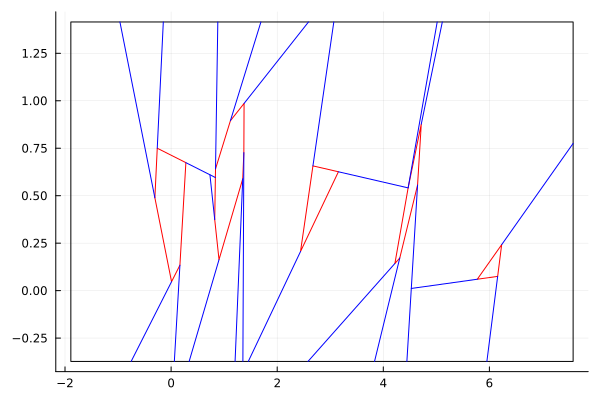

In [28]:
plot(xs[1][:],ys[1][:], linecolor = :red)
for i in 2:n_obstacle
    plot!(xs[i][:],ys[i][:], linecolor = :red)
end
plot!(xmap, ymap, linecolor = RGB(0,0,0), legend = false)
for i in 1:all_vertices-1
    plot!(x_free[i,:],y_free[i,:], linecolor = :blue)
end
plot!(x_free[all_vertices,:],y_free[all_vertices,:], linecolor = :blue, legend = false)


In [29]:
obstacle

5-element Vector{Any}:
 Any[Point(0.008391792231724704, 0.047), Point(-0.30600000000000005, 0.489), Point(-0.26119772506056305, 0.7500000000000001), Point(0.2783041476078988, 0.674), Point(0.16617664087741468, 0.13400000000000006)]
 Any[Point(0.9030486104036403, 0.163), Point(0.8223041476078988, 0.374), Point(0.8372291495962032, 0.641), Point(1.118045209529257, 0.895), Point(1.3755728594660663, 0.986), Point(1.371291634250416, 0.727), Point(1.35054421815645, 0.589)]
 Any[Point(2.4395728594660664, 0.206), Point(2.6736528332396414, 0.657), Point(3.1536950157998325, 0.626)]
 Any[Point(4.218695015799833, 0.14300000000000002), Point(4.468766748725655, 0.542), Point(4.715764327225456, 0.877), Point(4.646144449948692, 0.556), Point(4.31077848567411, 0.172)]
 Any[Point(5.771764327225456, 0.06), Point(6.231395901876568, 0.242), Point(6.155742746396467, 0.07500000000000001)]